# Spaceship Titanic
For my final project I wanted to try and solve the Spaceship Titanic competition from Kaggle

https://www.kaggle.com/competitions/spaceship-titanic

## Description of the Problem/Data

**Description**
After spaceship accident we are tasked to predict which passangers were transported due to the accident based on record recovered from the spaceship

**Data**
The dataset is a set of records for 8700 passangers with the following information
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
!pip -q install kaggle matplotlib seaborn

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

2024-04-26 14:12:35.993586: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 14:12:35.993616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 14:12:35.994518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 14:12:35.999539: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!kaggle competitions download -c spaceship-titanic
!unzip spaceship-titanic.zip

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spaceship-titanic.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Exploratory Data Analysis

In [23]:
data = pd.read_csv('train.csv')

# Check the shape of the dataset
print("Dataset shape:", data.shape)

# Display the first few rows of the dataset
print("First few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Calculate the percentage of missing values for each feature
print("\nPercentage of missing values:")
print(data.isnull().mean() * 100)

print("\nHANDLING MISSING VALUES")
# Impute missing values in numerical features with mean
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].mean())

# Impute missing values in categorical features with mode
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

# Create a separate category for missing values in 'Cabin'
data['Cabin'] = data['Cabin'].fillna('Unknown')

# Impute missing values in 'Name' based on domain knowledge or leave them as is
data['Name'] = data['Name'].fillna('Unknown')

Dataset shape: (8693, 14)
First few rows:
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        Fa

Descriptive Statistics by Transported:
                Age                                                     \
              count       mean        std  min   25%   50%   75%   max   
Transported                                                              
False        4315.0  29.900275  13.558108  0.0  21.0  28.0  38.0  79.0   
True         4378.0  27.771017  14.995903  0.0  18.0  27.0  37.0  78.0   

            RoomService              ...    Spa           VRDeck              \
                  count        mean  ...    75%      max   count        mean   
Transported                          ...                                       
False            4315.0  385.528247  ...  431.0  22408.0  4315.0  538.649578   
True             4378.0   66.161506  ...    0.0   4103.0  4378.0   74.424342   

                                                         
                     std  min  25%  50%    75%      max  
Transported                                              
False        15

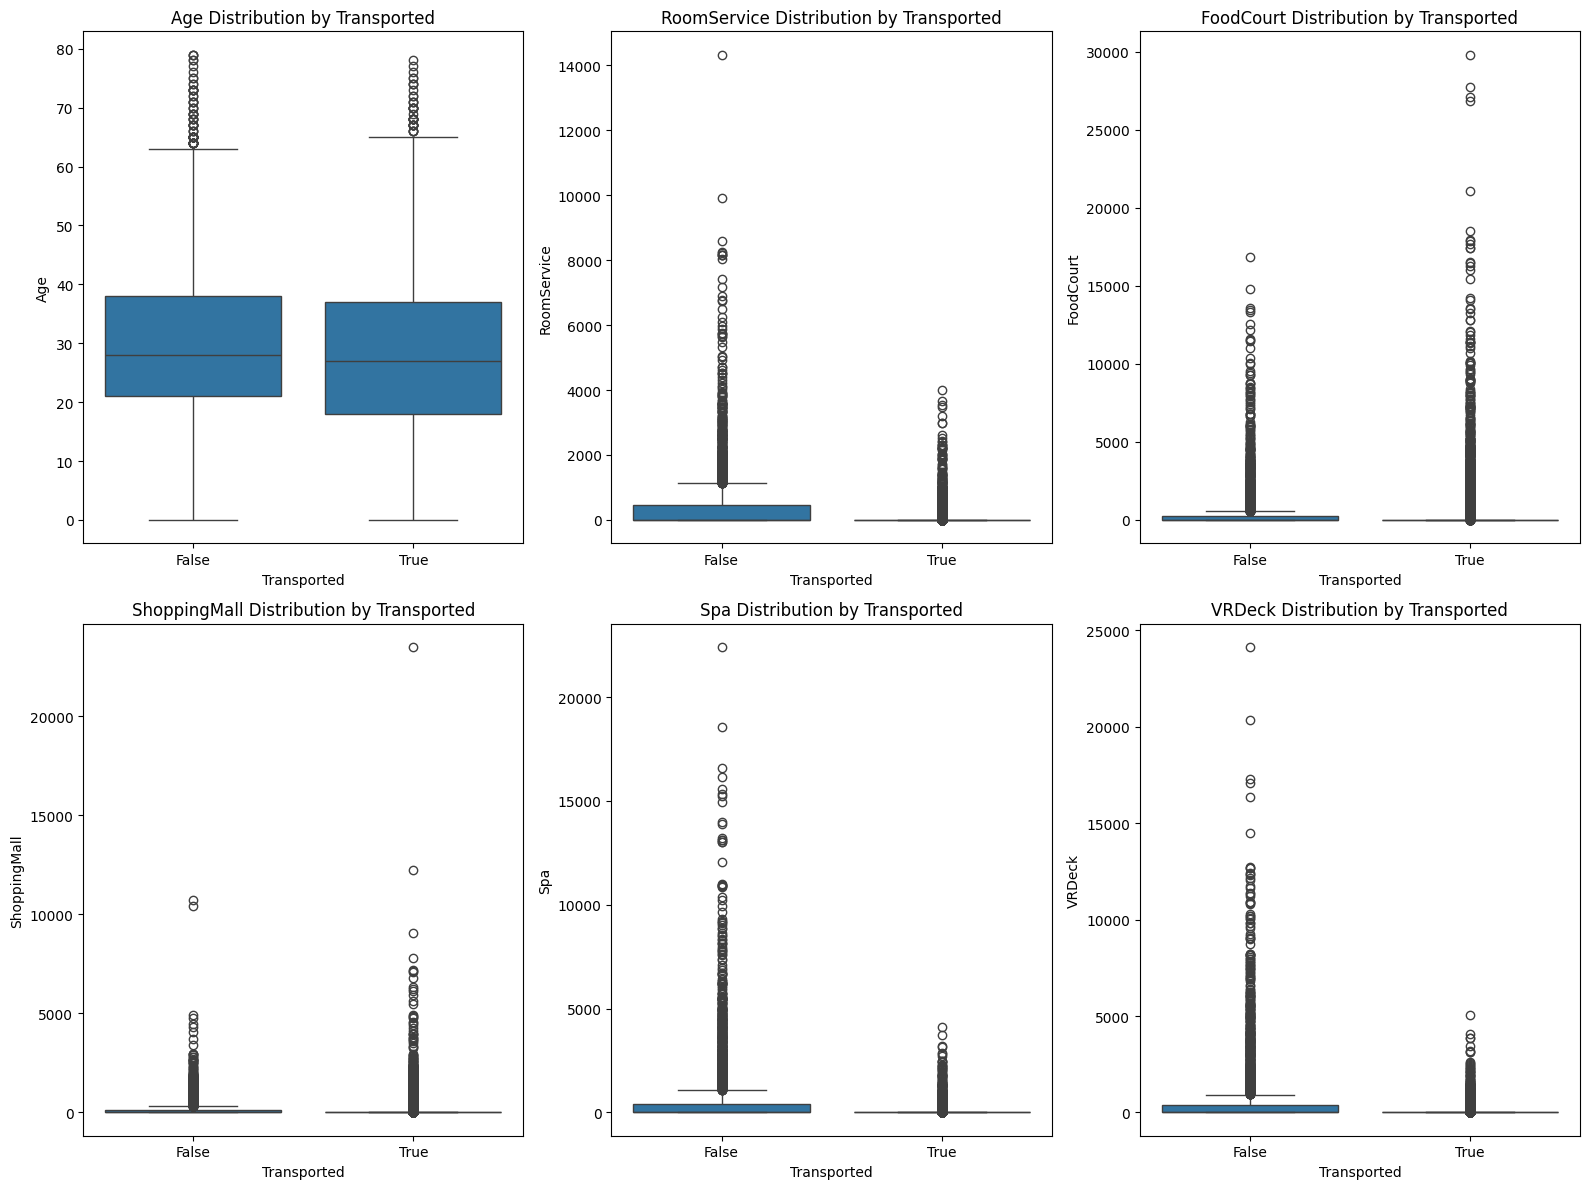

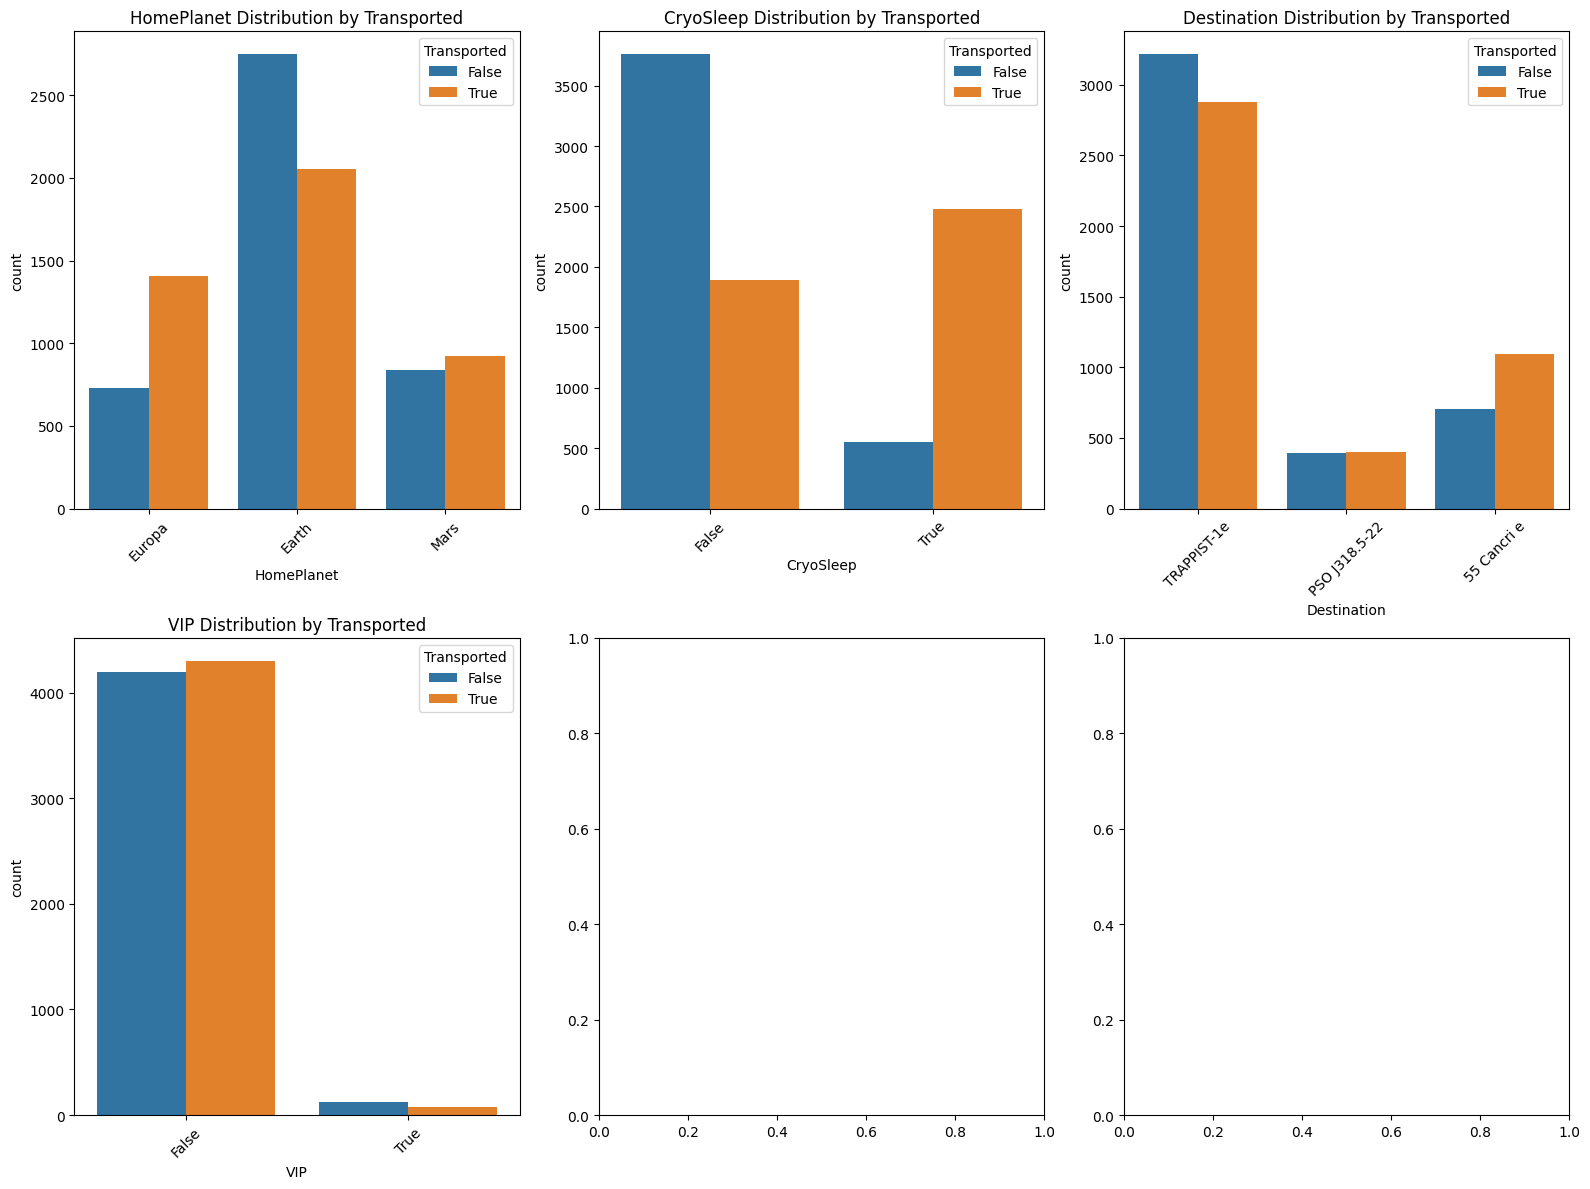

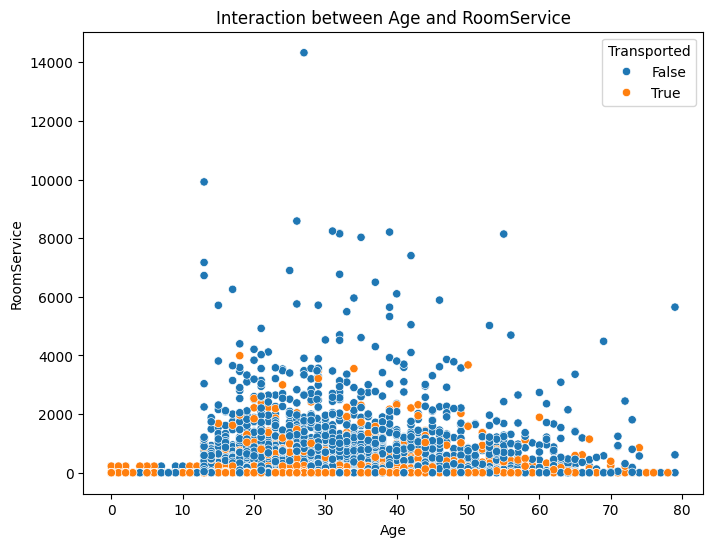

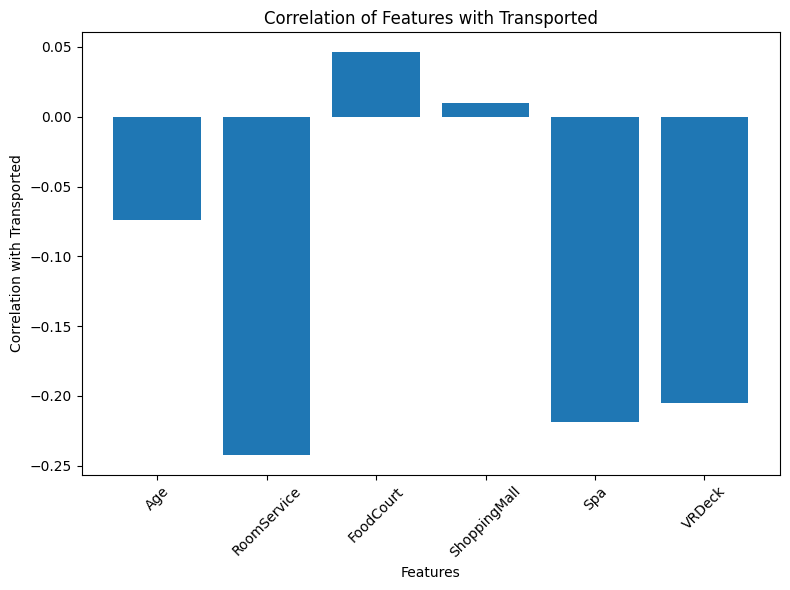

In [24]:
print("Descriptive Statistics by Transported:")
print(data.groupby('Transported').describe())

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
num_plots = len(numerical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Transported', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f"{feature} Distribution by Transported")

plt.tight_layout()
plt.show()
    
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
num_plots = len(categorical_features)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Transported', data=data, ax=axes[i])
    axes[i].set_title(f"{feature} Distribution by Transported")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
    
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Age', y='RoomService', hue='Transported', data=data)
plt.title("Interaction between Age and RoomService")
plt.show()
    
corr_with_target = data[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']].corr()['Transported'][:-1]
plt.figure(figsize=(8, 6))
plt.bar(corr_with_target.index, corr_with_target.values)
plt.xlabel('Features')
plt.ylabel('Correlation with Transported')
plt.title('Correlation of Features with Transported')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analysis

#### Demographic and Status Variables:
* Age: Passengers who were not transported have a higher average age (29.9 years) compared to those who were transported (27.77 years). This suggests younger passengers are more likely to be transported.
* CryoSleep: A significant predictor with a very strong association with the transportation status; passengers in cryosleep are far more likely to be transported.
* VIP: There is a statistically significant difference in transportation status between VIP and non-VIP passengers, though fewer VIP passengers are transported.

#### Expenditure Variables:
* RoomService, Spa, and VRDeck: Passengers who were not transported have much higher expenditures in these categories compared to those who were transported. This suggests that passengers who engage more with luxury services are less likely to be transported.
* FoodCourt and ShoppingMall: While the mean expenditures for these amenities are not as starkly different between the two groups, transported passengers tend to spend less on average, which might indicate lesser engagement with certain types of services.

#### HomePlanet and Destination:
* HomePlanet: Passengers from Europa are more likely to be transported than those from Earth or Mars, suggesting planetary origin may influence transportation likelihood.
* Destination: There is a variation in transport rates based on destination, with 55 Cancri e showing a higher proportion of transported passengers.

#### Correlations:
* Negative correlations between RoomService, Spa, and VRDeck expenditures and the probability of being transported suggest a pattern where higher spenders on luxury services are less likely to be transported.


## Data Preparation

* Group Size: Extract the group size from the PassengerId to determine if traveling in larger or smaller groups affects transportation status.
* Cabin Details: Parse the Cabin feature to separate into Deck, Num, and Side which could have potential predictive power.
* Age Categories: Convert Age into categorical bins (Child, Teen, Adult, Senior) to capture non-linear effects on transportation.
* Apply one-hot encoding to categorical variables like HomePlanet, Destination, and the extracted cabin features to make them suitable for model training.
* Scale expenditure features and age using standard scaling to normalize distributions and improve model convergence during training.
* Balancing the Dataset


In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

target = data['Transported']
features = data.drop('Transported', axis=1)

# Feature engineering
features['GroupSize'] = features['PassengerId'].apply(lambda x: x.split('_')[0]).map(features['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts())
features[['Deck', 'Num', 'Side']] = features['Cabin'].str.split('/', expand=True)
features['AgeCategory'] = pd.cut(features['Age'], bins=[0, 12, 18, 60, 100], labels=['Child', 'Teen', 'Adult', 'Senior'])

# Define categorical and numerical columns
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'AgeCategory']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']

# Encoding categorical variables and scaling numeric features
ohe_cols = categorical_cols + ['Deck', 'Side']
scale_cols = numerical_cols

# Define a column transformer to handle scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ])

# Create a pipeline with the preprocessing steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply transformations
X_prepared = pipeline.fit_transform(features)

# Extract feature names after one-hot encoding
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

# Converting the transformed array back to a DataFrame for better visualization and understanding
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)

# Description of the prepared dataset
description = X_prepared_df.describe()

print(description)

# Ensure the target is ready for use in training or validation
print(target.head())

                Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8.693000e+03  8.693000e+03  8.693000e+03  8.693000e+03  8.693000e+03   
mean  -1.761440e-16  5.987260e-17  7.356361e-17  7.724179e-17 -5.803351e-17   
std    1.000058e+00  1.000058e+00  1.000058e+00  1.000058e+00  1.000058e+00   
min   -2.010564e+00 -3.405899e-01 -2.873140e-01 -2.908170e-01 -2.766634e-01   
25%   -6.156918e-01 -3.405899e-01 -2.873140e-01 -2.908170e-01 -2.766634e-01   
50%   -1.274865e-01 -3.405899e-01 -2.873140e-01 -2.908170e-01 -2.766634e-01   
75%    5.699497e-01 -2.223546e-01 -2.133024e-01 -2.154885e-01 -1.975250e-01   
max    3.499182e+00  2.137681e+01  1.841192e+01  3.903403e+01  1.964845e+01   

             VRDeck     GroupSize  HomePlanet_Earth  HomePlanet_Europa  \
count  8.693000e+03  8.693000e+03       8693.000000        8693.000000   
mean  -6.436816e-17 -1.307798e-17          0.552514           0.245140   
std    1.000058e+00  1.000058e+00          0.497263           0.43

## Model Architecture Exploration

The following models have been chosen to try:

#### Logistic Regression
Logistic Regression is a fundamental model for binary classification problems. It's computationally efficient and provides a good baseline for performance. It works well when the relationship between the input features and the target variable is approximately linear.

##### Experiments
* C (Regularization strength): Controls the amount of overfitting (smaller values specify stronger regularization).
* Penalty: Specifies the norm used in the penalization ('l1' or 'l2').
* Solver: Algorithm to use in the optimization problem ('liblinear' is good for small datasets, 'saga' is efficient for larger ones with multinomial loss).

#### Random Forest
Random Forest is an ensemble learning method based on decision trees. It is robust against overfitting and effective in handling categorical features and interactions between features without requiring scaling.

##### Experiments
* n_estimators: Number of trees in the forest.
* max_depth: Maximum depth of each tree (helps control overfitting).
* min_samples_split: Minimum number of samples required to split an internal node.
* max_features: Number of features to consider when looking for the best split (e.g., 'sqrt', 'log2').

#### Gradient Boosting Machines
GBMs are powerful for classification problems, known for their high accuracy by combining weak learners sequentially, each correcting its predecessor. They are highly flexible and can capture complex nonlinear relationships.

##### Experiments
* learning_rate: Shrinks the contribution of each tree by this factor.
* n_estimators: Number of boosting stages to perform (too many can lead to overfitting).
* max_depth: Controls the depth of each tree.
* subsample: Fraction of samples to be used for fitting the individual base learners.

GridSearchCV is use to set up the hyperparameter tuning experiments

Best Score for LogisticRegression: 0.7963761863675582
Best Parameters for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


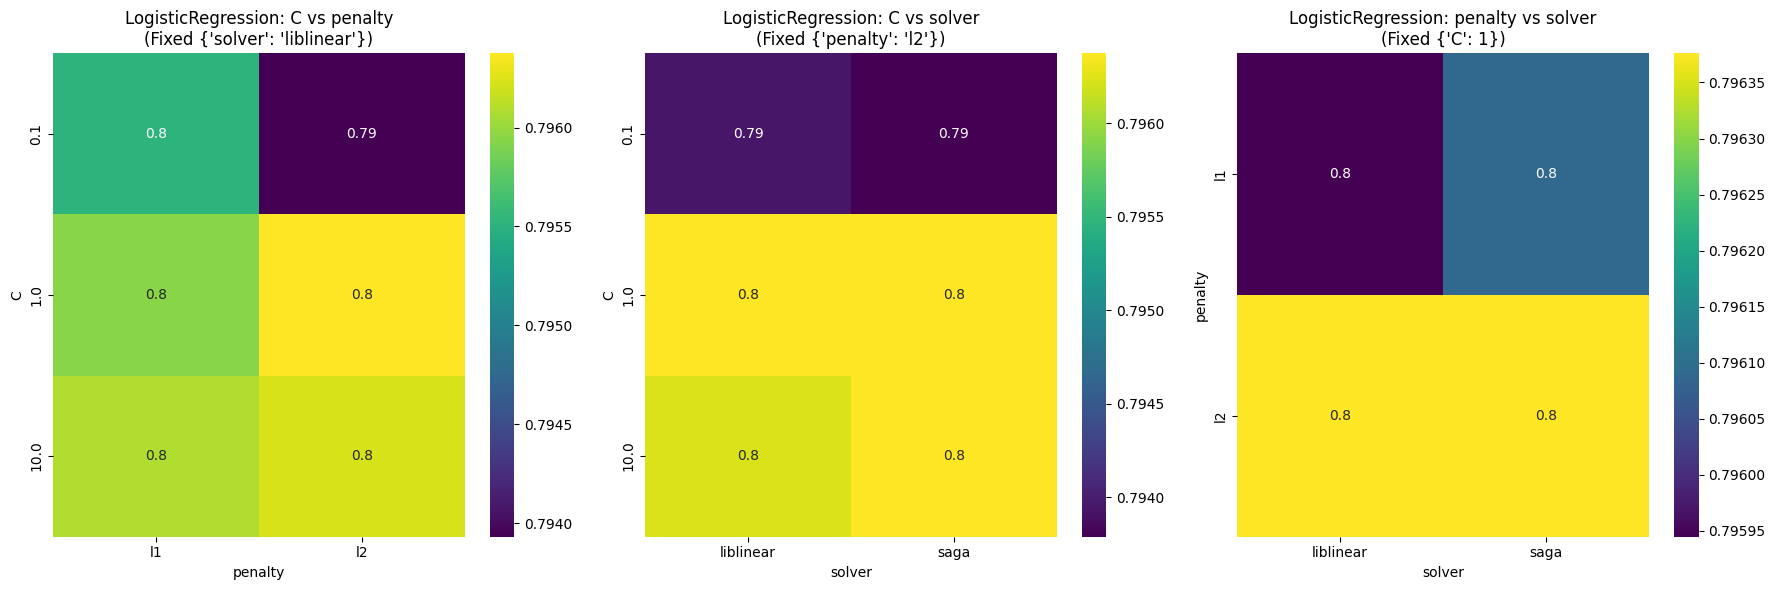

Best Score for RandomForest: 0.8009778544722462
Best Parameters for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}


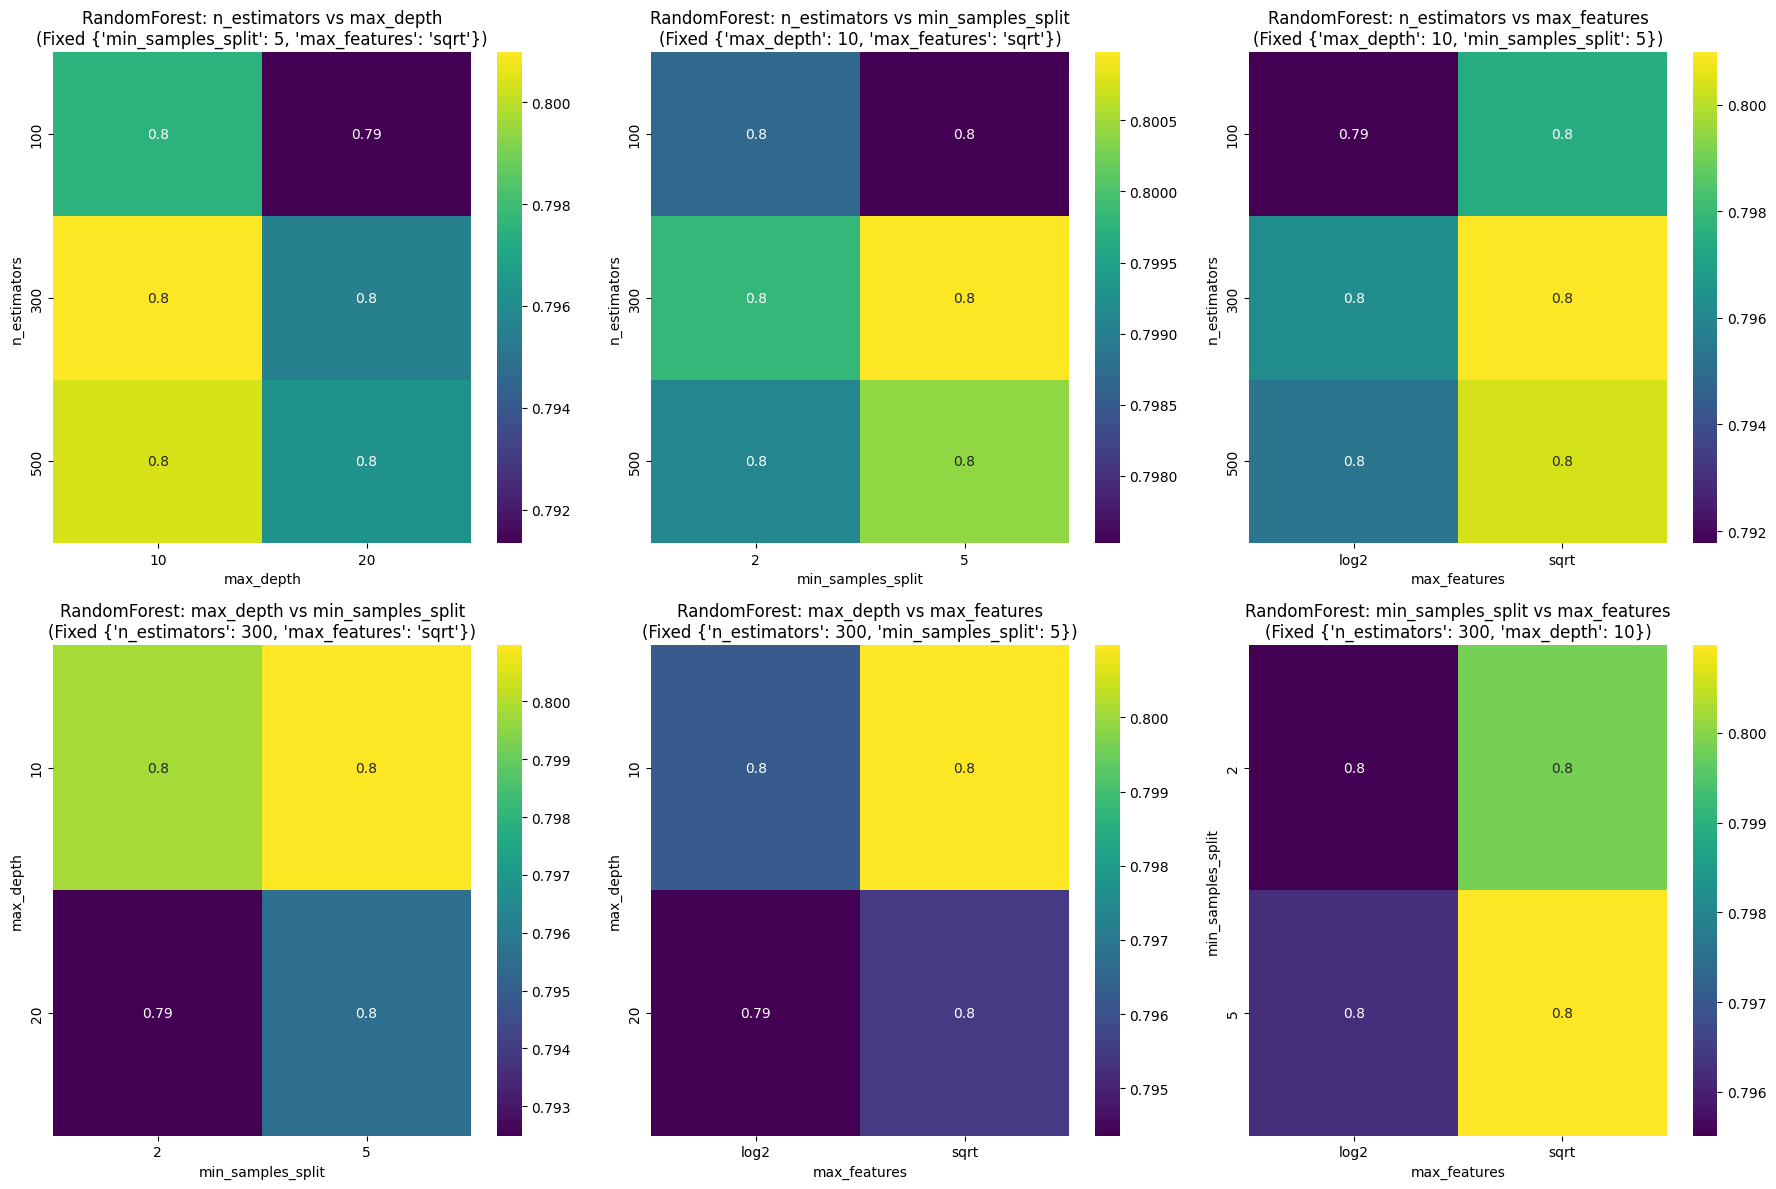

Best Score for GradientBoosting: 0.8061547310900202
Best Parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


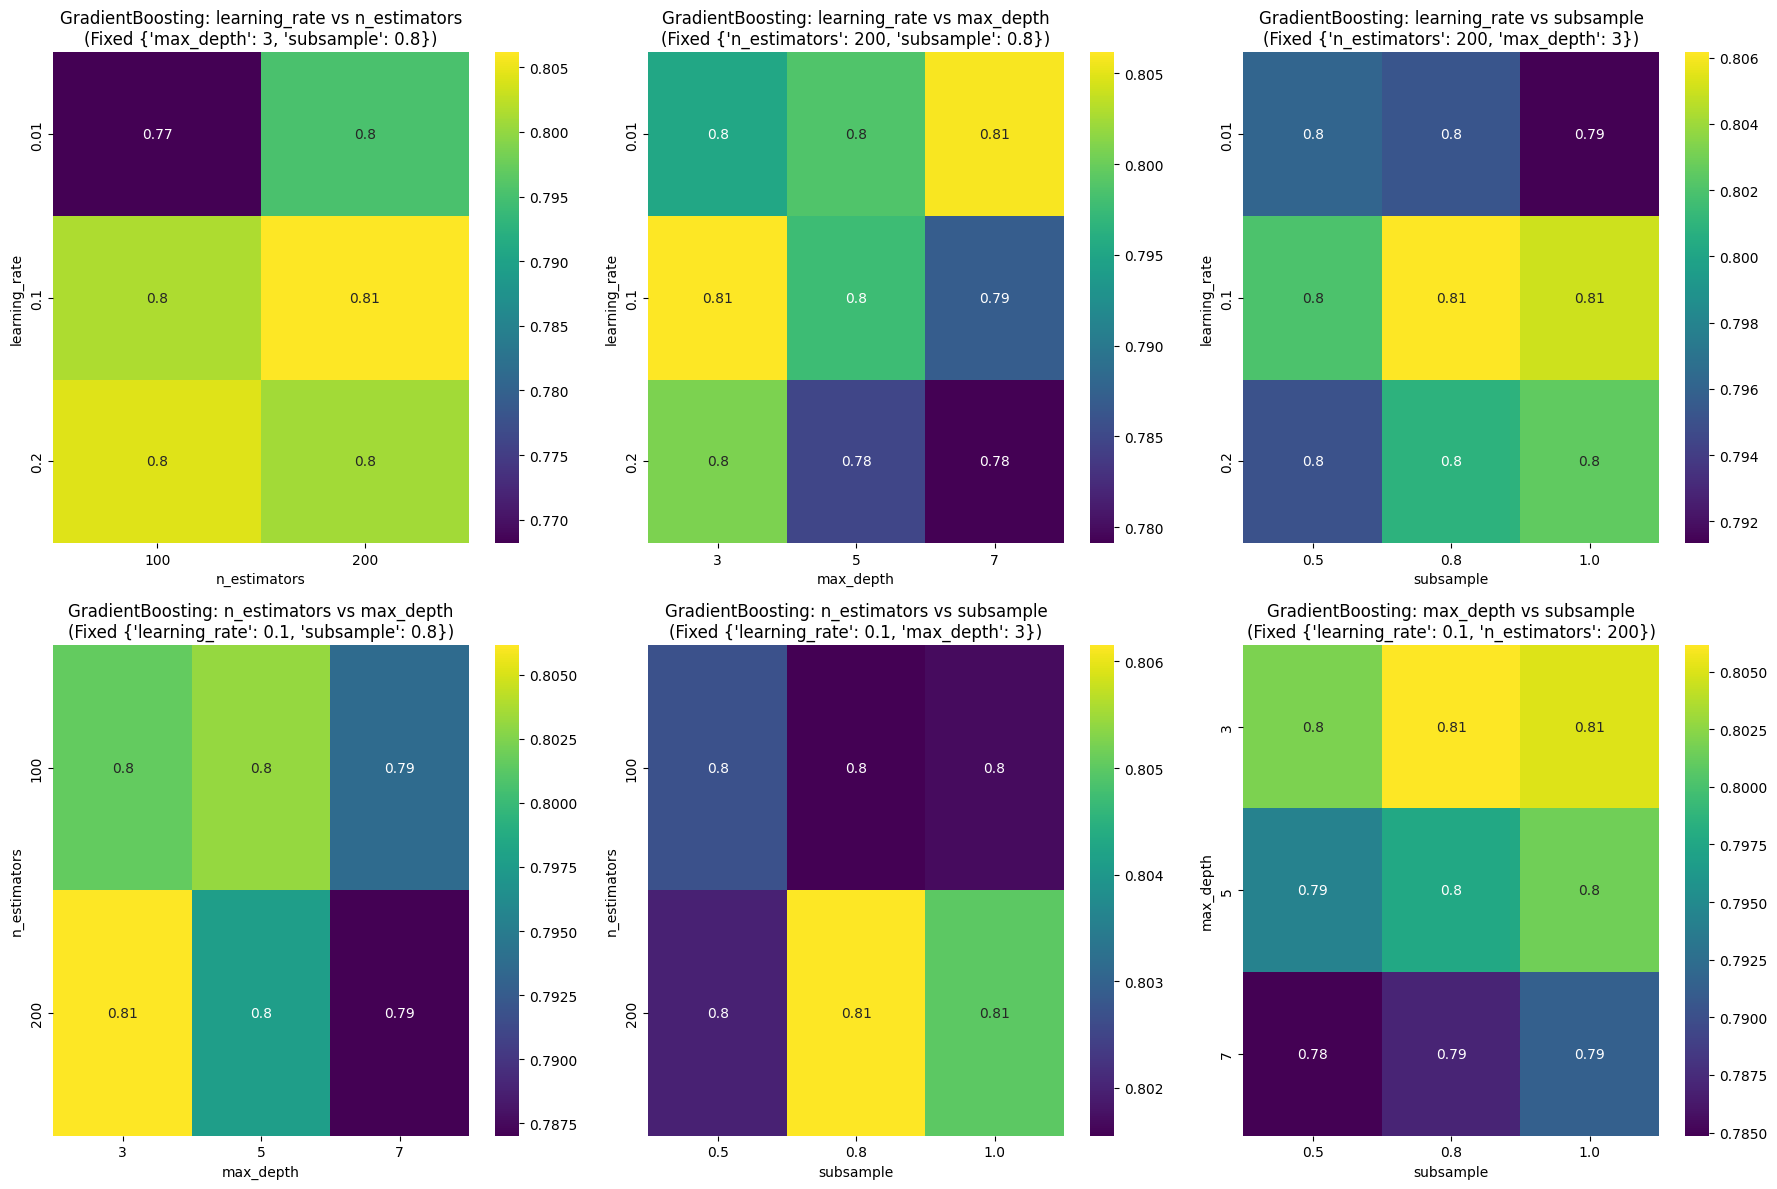

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from itertools import combinations
from math import ceil

X_train, X_test, y_train, y_test = train_test_split(X_prepared_df, target, test_size=0.2, random_state=42)

models_params = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [100, 300, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'max_features': ['sqrt', 'log2']}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'subsample': [0.5, 0.8, 1.0]}
    }
}

def run_grid_search_and_plot(models_params):
    for model_name, mp in models_params.items():
        grid_search = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Best parameters and score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score for {model_name}: {best_score}")
        print(f"Best Parameters for {model_name}: {best_params}")

        # Generate all combinations of parameters for pairwise heatmaps
        param_keys = list(mp['params'].keys())
        combinations_of_params = list(combinations(param_keys, 2))
        num_combinations = len(combinations_of_params)

        # Set up subplot grid
        rows = ceil(num_combinations / 3)
        fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
        
        # Convert axes to a 1D array for easier indexing
        axes = axes.ravel()

        # Plot each combination
        for idx, (param1, param2) in enumerate(combinations_of_params):
            ax = axes[idx]

            # Filter DataFrame for best other parameters
            results_df = pd.DataFrame(grid_search.cv_results_)
            fixed_params = {k: best_params[k] for k in param_keys if k not in [param1, param2]}
            mask = np.array([True] * len(results_df))
            for key, value in fixed_params.items():
                if f'param_{key}' in results_df:
                    mask = mask & (results_df[f'param_{key}'].values == value)
            filtered_df = results_df[mask]
            
            if filtered_df.empty:
                ax.axis('off')  # Turn off axis if no data to plot
                continue

            # Pivot table and plot
            try:
                pivot_table = filtered_df.pivot_table(values='mean_test_score',
                                                      index=f'param_{param1}',
                                                      columns=f'param_{param2}',
                                                      aggfunc=np.max)
                sns.heatmap(pivot_table, annot=True, cmap='viridis', ax=ax)
                ax.set_title(f'{model_name}: {param1} vs {param2}\n(Fixed {fixed_params})')
                ax.set_xlabel(param2)
                ax.set_ylabel(param1)
            except ValueError:
                ax.axis('off')  # Turn off axis if pivot table fails

        # Adjust layout and clear empty subplots if any
        plt.tight_layout()
        if num_combinations % 3 != 0:  # Clear any unused axes
            for ax in axes[num_combinations:]:
                ax.axis('off')
        plt.show()

# Running the experiment and plotting
run_grid_search_and_plot(models_params)

Let run a second round of experiments, adjusted based on the initial results, to see if we can do better

Best Score for LogisticRegression: 0.7965199884958297
Best Parameters for LogisticRegression: {'C': 20, 'penalty': 'l1', 'solver': 'liblinear'}


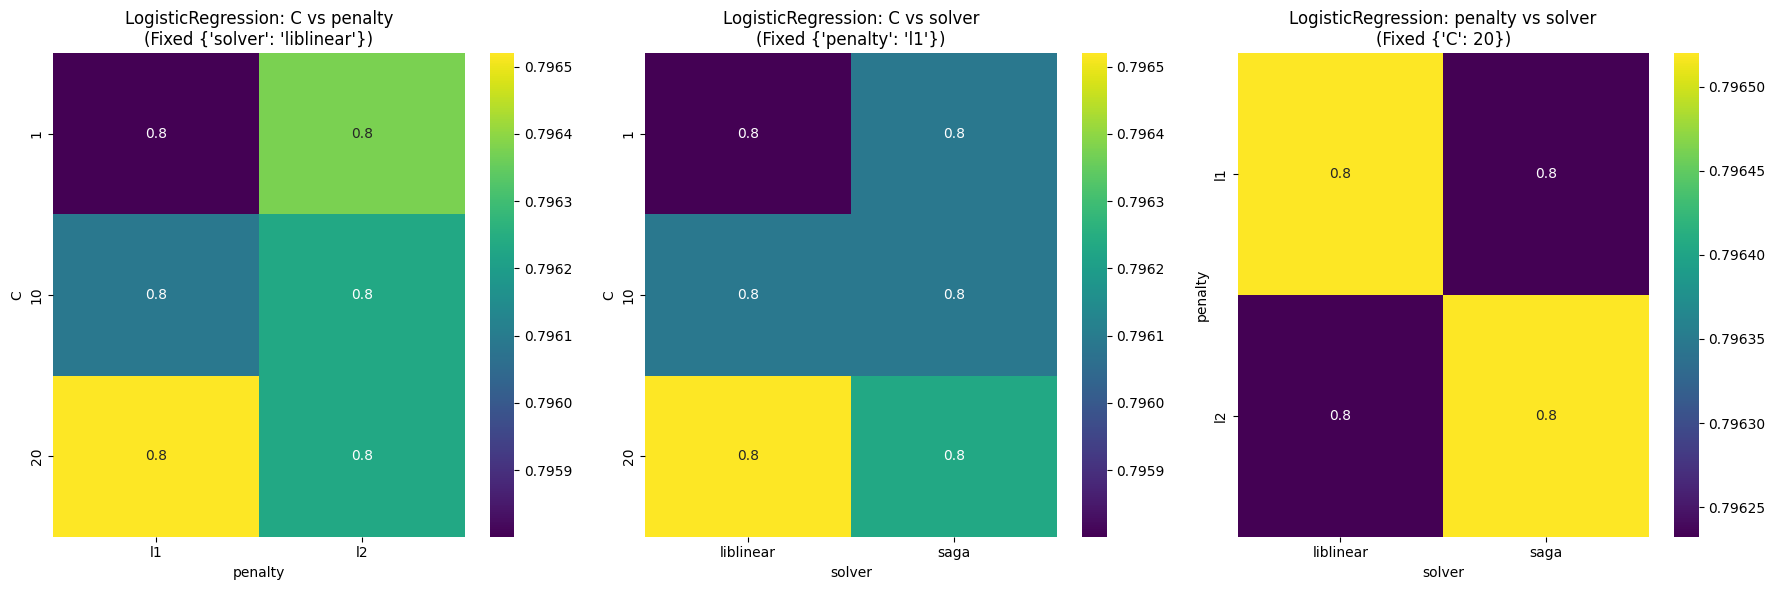

Best Score for RandomForest: 0.7965199884958297
Best Parameters for RandomForest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}


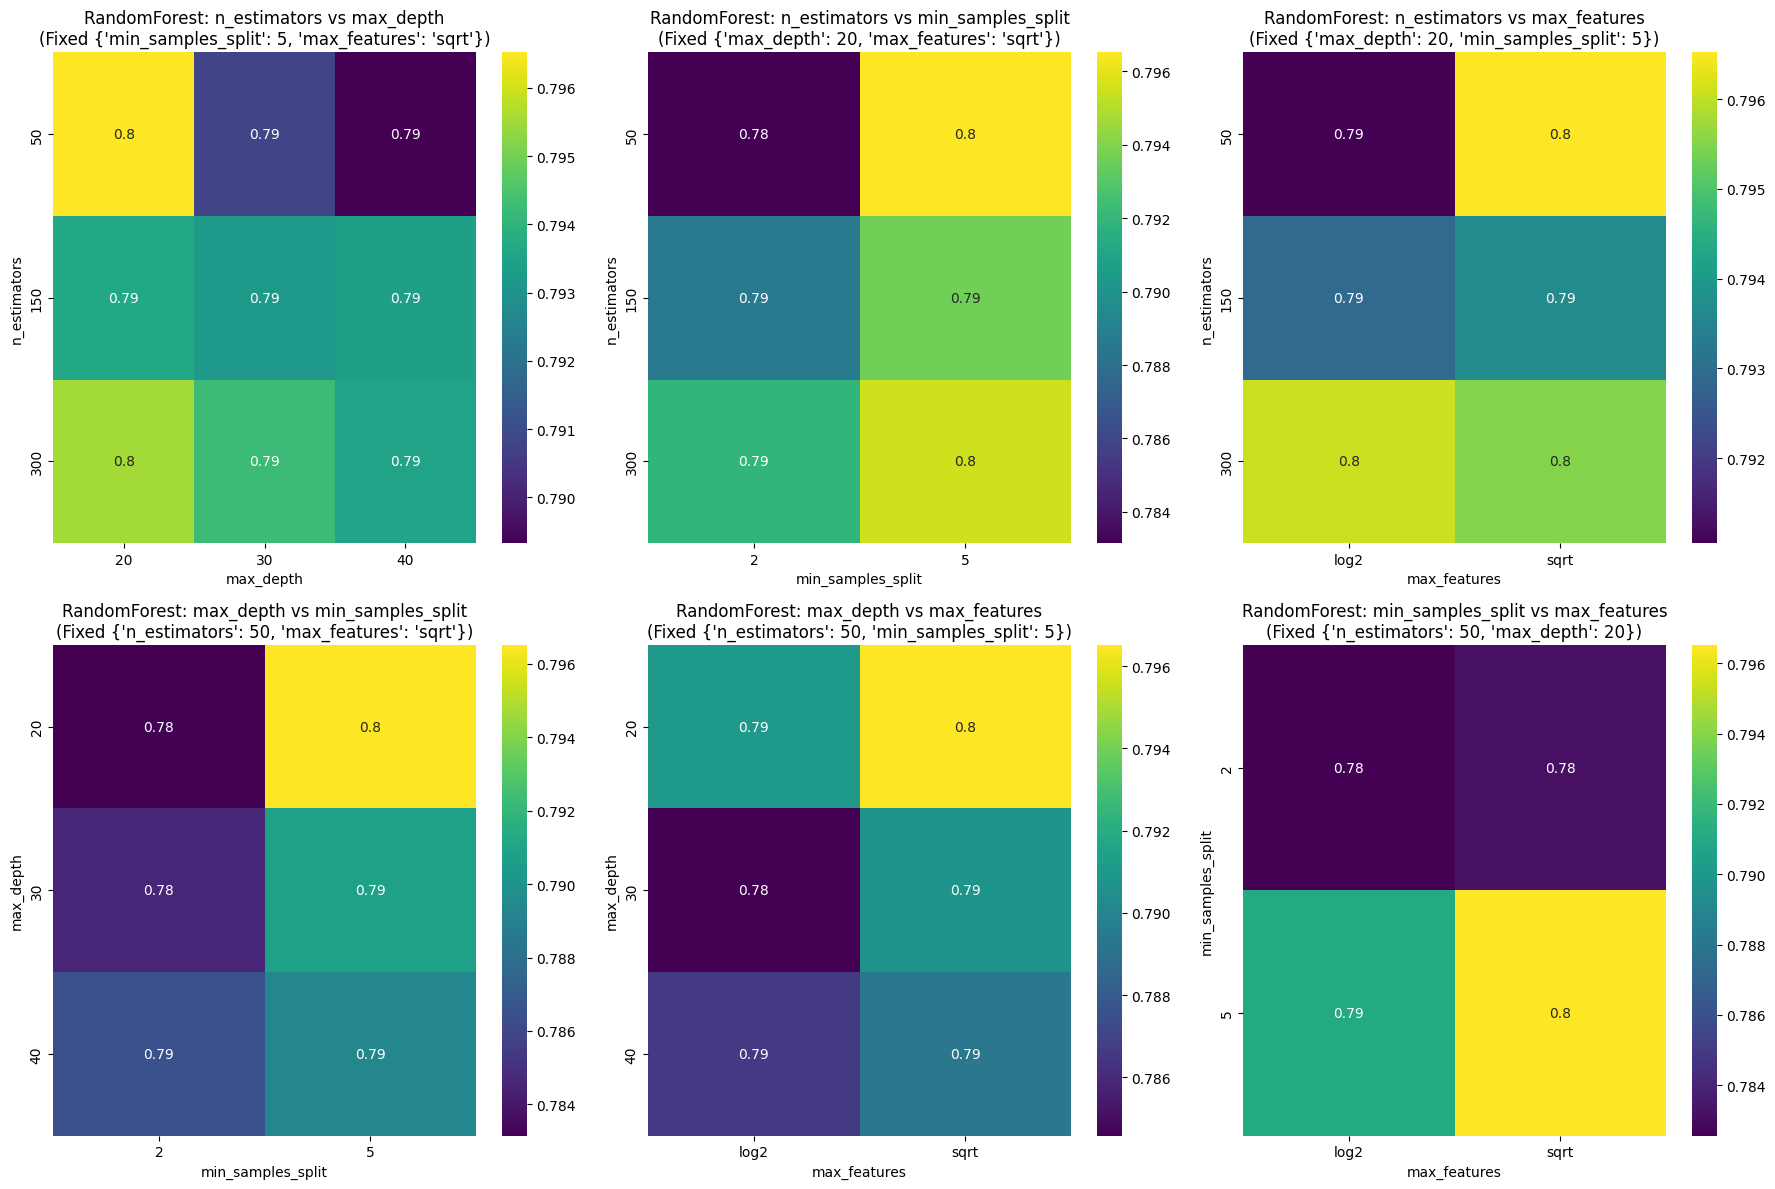

Best Score for GradientBoosting: 0.808455565142364
Best Parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


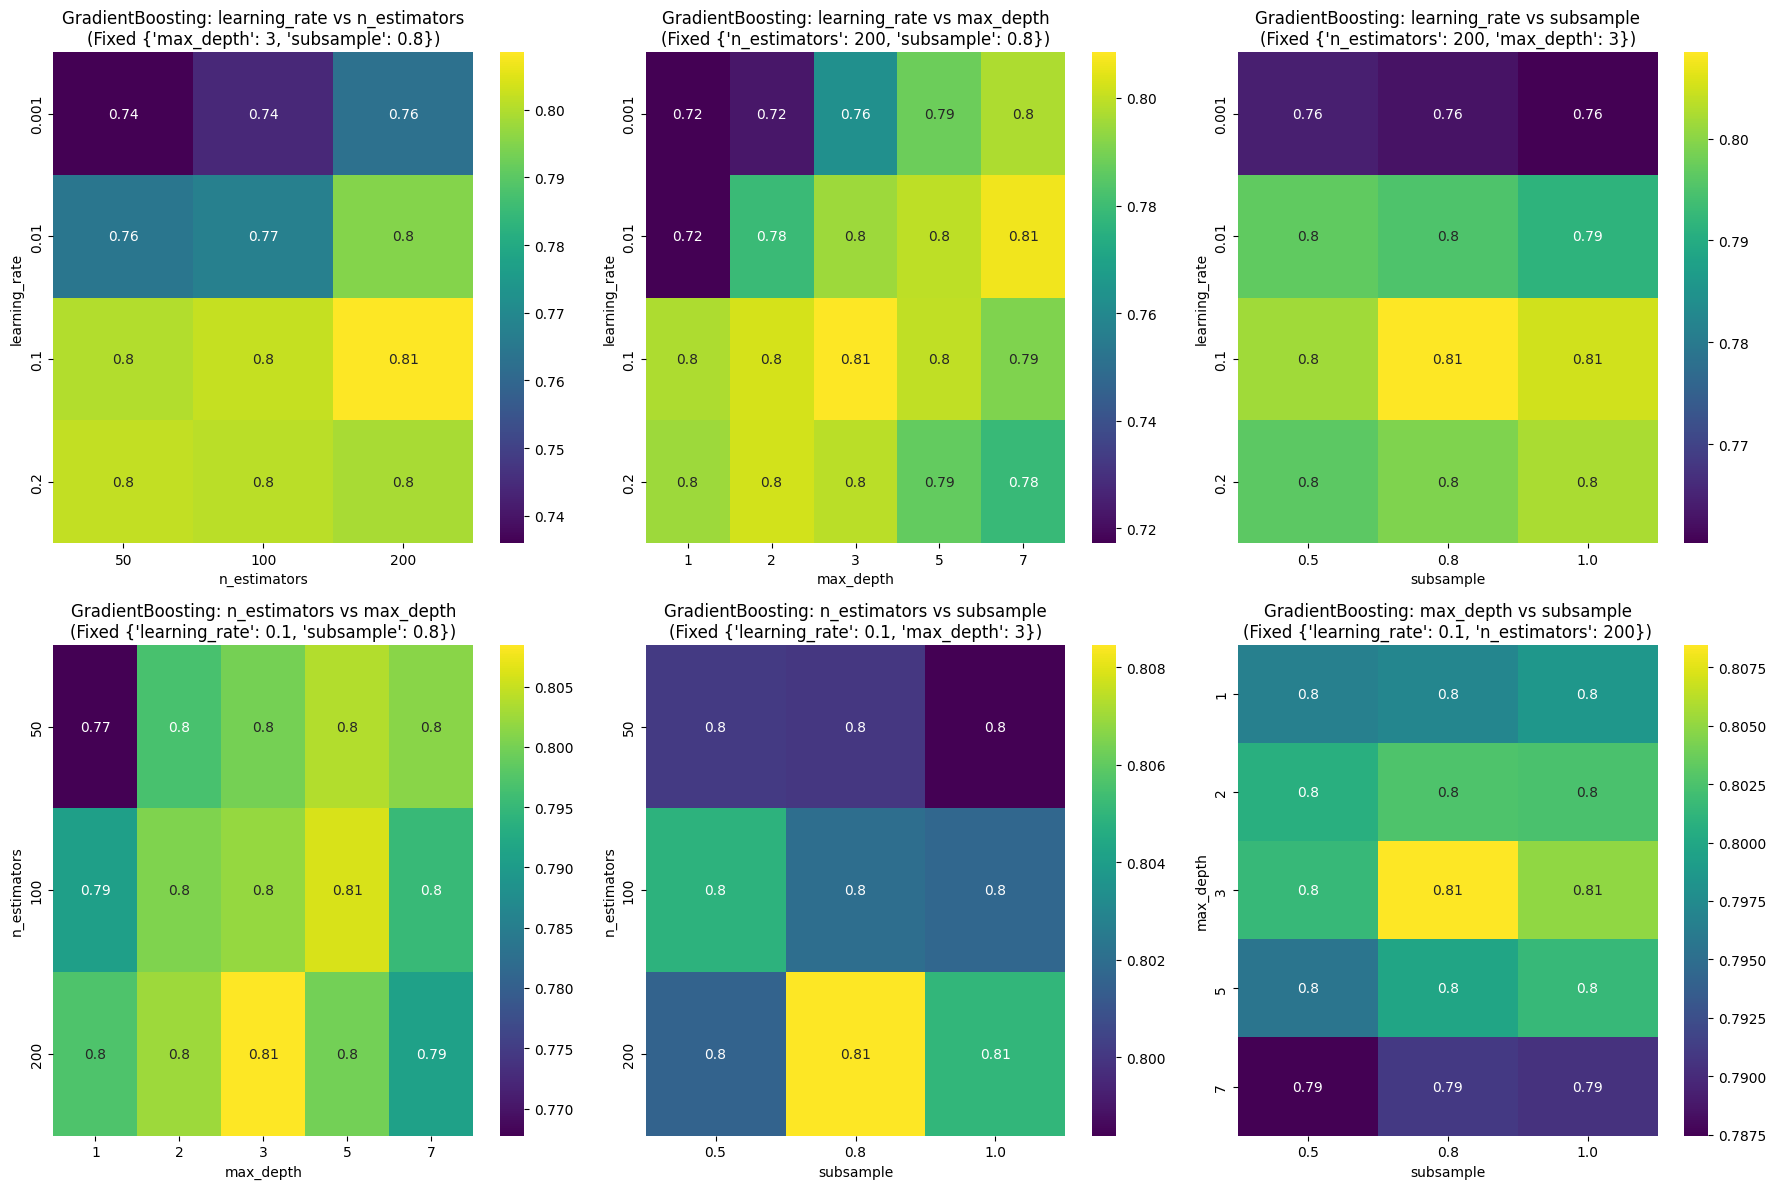

In [47]:
models_params = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [1, 10, 20], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 150, 300], 'max_depth': [20, 30, 40], 'min_samples_split': [2, 5], 'max_features': ['sqrt', 'log2']}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'learning_rate': [0.001, 0.01, 0.1, 0.2], 'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3, 5, 7], 'subsample': [0.5, 0.8, 1.0]}
    }
}

run_grid_search_and_plot(models_params)

#### Scores

Best Score for LogisticRegression: **0.7965199884958297**
Best Parameters for LogisticRegression: {'C': 20, 'penalty': 'l1', 'solver': 'liblinear'}

Best Score for RandomForest: **0.8009778544722462**
Best Parameters for RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}

Best Score for GradientBoosting: **0.808455565142364**
Best Parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

All three models have roughly the same accuracy, lets see we can take advantage of combining them.

### Combination Experiments

#### Voting Classifier
In a voting classifier, the predicted output class is the one that gets the most votes from the models.

#### Stacking
Stacking involves training a new model to combine the predictions of several base models. In this approach, the first-level individual models are trained based on the complete training set, then the second-level model is trained on the outputs (predictions) of the first-level models as features. 

In [56]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

model_lr = LogisticRegression(C=10, penalty='l1', solver='liblinear')
model_rf = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=5, n_estimators=300)
model_gb = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8)

voting_clf = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('gb', model_gb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

accuracy = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Accuracy - Soft: {accuracy}")

voting_clf = VotingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('gb', model_gb)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

accuracy = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Accuracy - Hard: {accuracy}")

meta_learner = LogisticRegression()

# Create stacking model
stacking_model = StackingClassifier(
    estimators=[('lr', model_lr), ('rf', model_rf), ('gb', model_gb)],
    final_estimator=meta_learner
)

# Train stacking model
stacking_model.fit(X_train, y_train)

# Evaluate stacking model
stacking_accuracy = stacking_model.score(X_test, y_test)
print("Stacking Model Accuracy:", stacking_accuracy)

Voting Classifier Accuracy - Soft: 0.7924094307073031
Voting Classifier Accuracy - Hard: 0.7924094307073031
Stacking Model Accuracy: 0.7906843013225991


## Conclusion

Based on the conducted experiments, the following conclusions emerge:

The individual models achieved varying levels of performance. The Logistic Regression model attained an accuracy of approximately 79.65% with optimal hyperparameters: C=20, penalty='l1', and solver='liblinear'. The RandomForest model achieved an accuracy of about 80.10% with optimal hyperparameters: max_depth=10, max_features='sqrt', min_samples_split=5, and n_estimators=300. The GradientBoosting model outperformed others, reaching an accuracy of around 80.85% with optimal hyperparameters: learning_rate=0.1, max_depth=3, n_estimators=200, and subsample=0.8.

Regarding ensemble techniques, the Voting Classifier, employing both soft and hard voting, attained an accuracy of about 79.24%, falling short of individual model performance. The Stacking Model, combining predictions from multiple base models using a meta-learner, achieved an accuracy of approximately 79.07%. Although integrating diverse models, its performance slightly lagged behind the best-performing individual model, GradientBoosting.

In terms of model selection, GradientBoosting emerged as the top performer among the individual models, showcasing the highest accuracy and hence appears most suitable for predicting passenger transport status aboard the Spaceship Titanic.

Moving forward, further exploration could involve investigating additional ensemble techniques, feature engineering methods, or alternative model combinations to potentially enhance predictive performance. Additionally, fine-tuning hyperparameters and conducting more extensive cross-validation may provide insights into improving model robustness and generalization.

In summary, while the stacking approach demonstrated the potential of ensemble learning, GradientBoosting emerged as the top-performing model, highlighting its effectiveness in predicting passenger transport status based on the given dataset.